In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)
inspector.get_table_names()


['measurement', 'station']

In [11]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column)

{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}
{'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'date', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'prcp', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'tobs', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}


In [12]:
columns = inspector.get_columns('station')
for column in columns:
    print(column)

{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}
{'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'name', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'latitude', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'longitude', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'elevation', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}


# Exploratory Climate Analysis

<h3> Precipitation Analysis </h3>

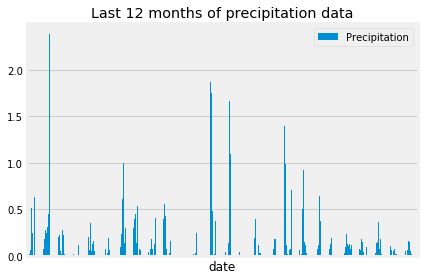

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

twelve_months_ago = dt.datetime.strptime(last_date[0], '%Y-%m-%d') - dt.timedelta(days=365)
twelve_months_ago

# Perform a query to retrieve the data and precipitation scores
prcp_last_twelve_months = session.query(Measurement.date, func.avg(Measurement.prcp)).\
    filter(Measurement.date > twelve_months_ago).\
    group_by(Measurement.date).\
    order_by(Measurement.date).all()

prcp_last_twelve_months

# Save the query results as a Pandas DataFrame and set the index to the date column
df_prcp_last_twelve = pd.DataFrame(prcp_last_twelve_months, columns=['date','prcp'])
df_prcp_last_twelve.set_index('date',inplace=True)
df_prcp_last_twelve
# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data
df_prcp_last_twelve.plot.bar()
plt.legend(['Precipitation'])
plt.xticks([])
plt.title("Last 12 months of precipitation data")
plt.tight_layout()
plt.show()

![precipitation](Images/precipitation.png)

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_prcp_last_twelve.describe()

,prcp
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


<h3> Station Analysis </h3>

![describe](Images/describe.png)

In [15]:
# Design a query to show how many stations are available in this dataset?
results_num_stations = session.query(func.count(Station.station)).all()
results_num_stations

[(9)]

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
results_stations_counts = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
results_stations_counts

station_id_most_active = results_stations_counts[0][0]
station_id_most_active

'USC00519281'

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
results_temp_most_active = session.query(func.min(Measurement.tobs), 
                                         func.max(Measurement.tobs),
                                         func.avg(Measurement.tobs)).\
    group_by(Measurement.station).\
    filter(Measurement.station == station_id_most_active).all()
results_temp_most_active

[(54.0, 85.0, 71.66378066378067)]

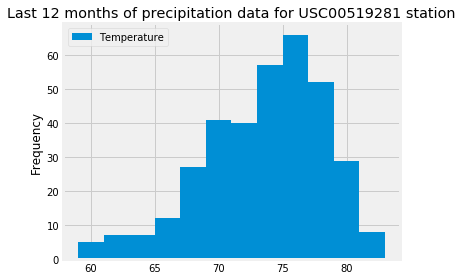

In [30]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_last_twelve_months = session.query(Measurement.date, func.avg(Measurement.tobs)).\
    filter(Measurement.date > twelve_months_ago).\
    group_by(Measurement.date).\
    filter(Measurement.station == station_id_most_active).\
    order_by(Measurement.date).all()
tobs_last_twelve_months

# Save the query results as a Pandas DataFrame and set the index to the date column
df_tobs_last_twelve = pd.DataFrame(tobs_last_twelve_months, columns=['date','tobs'])
df_tobs_last_twelve.set_index('date',inplace=True)
df_tobs_last_twelve
# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data
df_tobs_last_twelve.plot.hist(bins=12)
plt.legend(['Temperature'])
plt.title(f"Last 12 months of precipitation data for {station_id_most_active} station")
plt.tight_layout()
plt.show()

![precipitation](Images/station-histogram.png)

# Climate App

In [33]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [74]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start = '2016-09-15'
trip_end = '2016-09-25'

stats_trip = calc_temps(trip_start, trip_end)
stats_trip

[(70.0, 77.77142857142857, 83.0)]

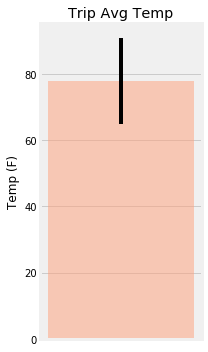

In [75]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


fig, ax = plt.subplots(figsize=(3,5))

y = stats_trip[0][1]
yerr = stats_trip[0][2] - stats_trip[0][0]
x = 1

ax.bar(x, y, width = 0.35, yerr = yerr, alpha = 0.5, color = 'lightsalmon')
plt.xticks([])
ax.set_title('Trip Avg Temp')
plt.ylabel('Temp (F)')
fig.tight_layout()


In [76]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rain_trip = session.query(Measurement.station, 
                          Station.name, 
                          Station.latitude, 
                          Station.longitude, 
                          Station.elevation, 
                          func.sum(Measurement.prcp)).\
    filter(Measurement.date >= trip_start).filter(Measurement.date <= trip_end).\
    filter(Measurement.station == Station.station).\
    group_by(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation).\
    order_by(func.sum(Measurement.prcp).desc()).all()
rain_trip


[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  7.7),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  2.94),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.7300000000000001),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  0.5900000000000001),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.55),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.32),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.06)]

## Optional Challenge Assignment

In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [27]:
# Plot the daily normals as an area plot with `stacked=False`
